# Imports

In [33]:
user = 'notasha'
repo = 'ExperimentalDataProcessing'
src_dir = 'src'
data_dir = 'data'

pyfiles = ['data_generation.py', 'running_mean.py', 'exponential_smooth.py', 'indicators.py']
txtfiles = ['true_surface.txt', 'noisy_surface.txt']

for pyfile in pyfiles:
  url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
  !wget --no-cache --backups=1 {url}

for txtfile in txtfiles:
  url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{data_dir}/{txtfile}"
  !wget --no-cache --backups=1 {url}

--2022-06-21 21:04:25--  https://raw.githubusercontent.com/notasha/ExperimentalDataProcessing/main/src/data_generation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1782 (1.7K) [text/plain]
Saving to: ‘data_generation.py’

data_generation.py  100%[===================>]   1.74K  --.-KB/s    in 0s      

2022-06-21 21:04:25 (28.8 MB/s) - ‘data_generation.py’ saved [1782/1782]

--2022-06-21 21:04:25--  https://raw.githubusercontent.com/notasha/ExperimentalDataProcessing/main/src/running_mean.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 2

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Math

from data_generation import *
from running_mean import *
from exponential_smooth import *
from indicators import *

# **Exercise 1.** Comparison of the exponential and running mean for random walk model

## Generation of the true trajectory and its measurements

For generation of the true trajectory the random walk model is used
\begin{equation}
    X_i = X_{i-1} + w_i.
\end{equation}
Here, $X_i$ — true process to be estimated, $w_i$ — is normally distributed random noise with zero mathematical expectation and variance $\sigma_w^2 = 16$. Let's assume the initial condition is $X_1 = 10$.

The measurements $Z_i$ of the process $X_i$ are generated with the following equation
\begin{equation}
    Z_i = Z_{i-1} + \eta_i,
\end{equation}
where $\eta_i$ is a normally distributed random noise with zero mathematical expectation and variance $\sigma_{\eta}^2$=11

Size of trajectory can be large (for example, 3000 points) or small (for example, 300 points)

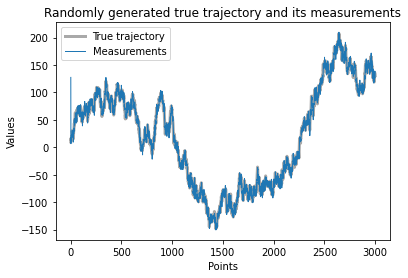

In [35]:
# Size of trajectory
N = 3000

# Noises
traj_sigma2 = 16
measure_sigma2 = 11

# Generate the true trajectory X_i using the random walk model
X, traj_noise = get_random_walk_true_trajectory(init_position=10, points_num=N, sigma2=traj_sigma2)
# Generate measurements Z_i of the process X_i
Z, measure_noise = get_measurements(trajectory=X, sigma2=measure_sigma2)

# Build plot for trajectory and measurements
points = np.linspace(1, N, N)
plt.plot(points, X, linewidth=3, color='darkgray', label='True trajectory')
plt.plot(points, Z, linewidth=1, color='tab:blue', label='Measurements')
plt.title('Randomly generated true trajectory and its measurements')
plt.ylabel('Values')
plt.xlabel('Points')
plt.legend()
plt.show()

## Exponential smoothing

### Determination of the optimal smoothing coefficient in exponential smoothing

Firstly, the variances $\sigma_w^2$ and $\sigma_{\eta}^2$ should be indentified. The following set of equations is used for this

\begin{equation}
    \nu_i = \omega_{i} + \eta_{i} - \eta_{i-1},
\end{equation}

\begin{equation}
    \rho_i = \omega_{i} + \omega_{i-1} + \eta_{i} - \eta_{i-2},
\end{equation}

\begin{equation}
    E[\nu_i^2] \approx \frac{1}{N-1}\sum_{k=2}^N \nu_k^2,
\end{equation}

\begin{equation}
    E[\rho_i^2] \approx \frac{1}{N-2}\sum_{k=3}^N \rho_k^2,
\end{equation}

\begin{equation}
    E[\nu_i^2] = \sigma_w^2 + 2\sigma_{\eta}^2
\end{equation}

\begin{equation}
    E[\rho_i^2] = 2\sigma_w^2 + 2\sigma_{\eta}^2
\end{equation}

Here, $E[\nu_i^2]$ and $E[\rho_i^2]$ are mathematical expectations.

Mathematical transformations were performed to get the variances

\begin{equation}
   \sigma_w^2 = E[\rho_i^2] - E[\nu_i^2], \qquad
   \sigma_{\eta}^2 =E[\nu_i^2] - \frac{E[\rho_i^2]}{2}.
\end{equation}

Substituting the last equation into the code, I get the following results at one of iterations
- for 3000 points: $\sigma_w \approx 16.7$, $\sigma_{\eta} \approx 11$
    \begin{equation}
    \Delta\sigma_w \approx 4.47\%, \quad \Delta\sigma_{\eta} \approx 0.22\%
    \end{equation}

- for 300 points: $\sigma_w = 17.2$, $\sigma_{\eta} = 10.1$.
    \begin{equation}
    \Delta\sigma_w \approx 7.32\% \quad \Delta\sigma_{\eta} \approx 8.32\%
    \end{equation}

Comparing two sizes of trajectories, one can note that the results for the bigger trajectory size are slightly better. 

The optimal smoothing coefficient $\alpha$ is estemated as
\begin{equation}
    \alpha = \frac{-\chi + \sqrt{\chi^2 + 4\chi}}{2}, \qquad \chi = \frac{\sigma_w^2}{\sigma_{\eta}^2}
\end{equation}

Performing 100 iterations we see that the optimal value of $\alpha$ is close to $0.7$, because it gives us variances that are close to the original ones.

In [36]:
alphas = []
for i in range(100):
    # Generate the true trajectory X_i using the random walk model
    X, traj_noise = get_random_walk_true_trajectory(init_position=10, points_num=N, sigma2=traj_sigma2)
    # Generate measurements Z_i of the process X_i
    Z, measure_noise = get_measurements(trajectory=X, sigma2=measure_sigma2)
    # Identifying of 𝜎𝑤2 and 𝜎𝜂2
    traj_sigma2_esimated, measure_sigma2_esimated = estimate_math_expectations(traj_noise, measure_noise)
    
    alphas.append(get_optimal_coefficient(traj_sigma2_esimated, measure_sigma2_esimated))

opt_alpha = sum(alphas) / len(alphas)
print('Optimal smoothing coefficient is', opt_alpha)

Optimal smoothing coefficient is 0.6972620739705124


### Exponential smoothing with the determined smoothing coefficient

Now, we can perform exponential smoothing and plot the results for both trajectory sizes. For this we use the following equation

\begin{equation}
    \hat{X}_i = \hat{X}_{i-1} + \alpha (z_i-\hat{X}_{i-1})
\end{equation}

The obtained results are shown in the plots below

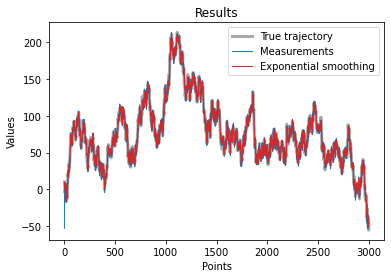

In [37]:
exp_smooth = exponential_smoothing(initial_state=10, measurements=Z, smooth_coefficient=opt_alpha)

# Build plot for trajectory and measurements
points = np.linspace(1, N, N)
plt.plot(points, X, linewidth=3, color='darkgray', label='True trajectory')
plt.plot(points, Z, linewidth=1, color='tab:blue', label='Measurements')
plt.plot(points, exp_smooth, linewidth=1, color='tab:red', label='Exponential smoothing')
plt.title('Results')
plt.ylabel('Values')
plt.xlabel('Points')
plt.legend()
plt.show()

## Comparison of exponential and running mean

Let's set $\sigma_w^2 = 28^2$, $\sigma_{\eta}^2 = 97^2$ here.

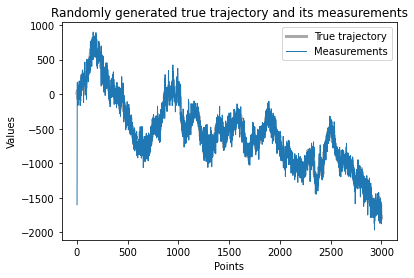

In [38]:
# Size of trajectory
N = 3000

# Noises
traj_sigma2 = 28**2
measure_sigma2 = 97**2

# Generate the true trajectory X_i using the random walk model
X, traj_noise = get_random_walk_true_trajectory(init_position=10, points_num=N, sigma2=traj_sigma2)
# Generate measurements Z_i of the process X_i
Z, measure_noise = get_measurements(trajectory=X, sigma2=measure_sigma2)

# build plot for measurements
points = np.linspace(1, N, N)
plt.plot(points, X, linewidth=3, color='darkgray', label='True trajectory')
plt.plot(points, Z, linewidth=1, color='tab:blue', label='Measurements')
plt.title('Randomly generated true trajectory and its measurements')
plt.ylabel('Values')
plt.xlabel('Points')
plt.legend()
plt.show()

### Exponential smoothing

The new optimal coefficient $\alpha$ for exponential smoothing would be around $0.24$ now.

In [39]:
alphas = []
for i in range(100):
    # Generate the true trajectory X_i using the random walk model
    X, traj_noise = get_random_walk_true_trajectory(init_position=10, points_num=N, sigma2=traj_sigma2)
    # Generate measurements Z_i of the process X_i
    Z, measure_noise = get_measurements(trajectory=X, sigma2=measure_sigma2)
    # Identifying of 𝜎𝑤2 and 𝜎𝜂2
    traj_sigma2_esimated, measure_sigma2_esimated = estimate_math_expectations(traj_noise, measure_noise)
    alphas.append(get_optimal_coefficient(traj_sigma2_esimated, measure_sigma2_esimated))

opt_alpha = sum(alphas) / len(alphas)
print('Optimal smoothing coefficient is', opt_alpha)

Optimal smoothing coefficient is 0.23303405219736686


In [40]:
exp_smooth = exponential_smoothing(initial_state=10, measurements=Z, smooth_coefficient=opt_alpha)

### Running mean

For implementing the running mean method, I determine the window size $M$ first

\begin{equation}
    \sigma^2_{RM} = \frac{\sigma^2_\eta}{M}, \qquad  \sigma^2_{ES} = \sigma^2_\eta\frac{\alpha}{2-\alpha}, \qquad  \sigma^2_{RM} = \sigma^2_{ES},
\end{equation}

where $RM$ is running mean and $ES$ stands for exponential smoothing.

After mathematical transformations, the formula for $M$ was obtained:
\begin{equation}
    M = \frac{2-\alpha}{\alpha} \Rightarrow M = 7 
\end{equation} 

In [41]:
# Find window size M and sigma
M = int((2 - opt_alpha)/opt_alpha)
RM_sigma2 = measure_sigma2_esimated / M
print(f'M = {M}  |  sigma = {np.sqrt(RM_sigma2)}')

M = 7  |  sigma = 36.10349465626721


Now, I apply running mean using determined window size 𝑀

In [42]:
run_mean = running_mean(measurements=Z, window_size=M)

### Comparison

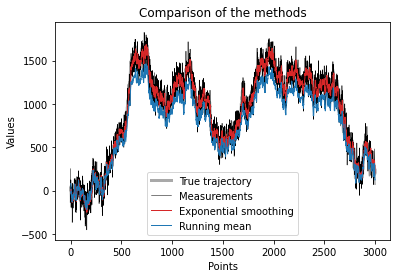

In [43]:
# Plot for comparison
plt.plot(points, X, linewidth=3, color='darkgray', label='True trajectory')
plt.plot(points, Z, linewidth=0.5, color='black', label='Measurements')
plt.plot(points, exp_smooth, linewidth=1, color='tab:red', label='Exponential smoothing')
plt.plot(points, run_mean, linewidth=1, color='tab:blue', label='Running mean')
plt.title('Comparison of the methods')
plt.ylabel('Values')
plt.xlabel('Points')
plt.legend()
plt.show()

## Conclusion

1. After a comparison of results for trajectories of 300 and 3000 points, one can see that for 300 points trajectory calculated variances differ more to input values than variances for 3000 points trajectory. 

2. In case of smaller $\alpha$, we get worse filtration of measurement errors, but better reaction to changes in the process. While in the case of bigger $\alpha$, we get better filtration, but worse reaction to changes, which leads to a big forward shift of the trajectory constructed by the exponential smoothing method.

3. Exponential smoothing method produced more methodological errors than the running mean method and caused the shift of its trajectory

# **Exercise 2.** Determining and removing drawbacks of exponential and running mean

## Backward exponential smoothing

Let's keep the same conditions from the previous exersice, where we worked with a random walk model with noise $\sigma_w = 28$ and $\sigma_\eta = 97$. There, we noticed a delay of estimations in case of applying exponential smoothing we noticed.

Now, we apply backward exponential smoothing to forward exponential estimates

\begin{equation}
    \begin{cases}
    X_i^b = X_{i+1}^b + \alpha (X_i^f - X_{i+1}^b), \quad i = N-1, ... 1 \\
    X_N^b = X_N^f.
    \end{cases}
\end{equation}

Here, index $f$ corresponds to forward smoothing and index $b$ to backward smoothing. As a result we get smoother measurement errors the curve shifts to left. I'll compare this to the previous results.

In [44]:
# Backward exponential smoothing with the optimal smoothing coefficient determined previously
backwrd_exp_smooth = backward_exponential_smoothing(exp_smooth, smooth_coefficient=opt_alpha)

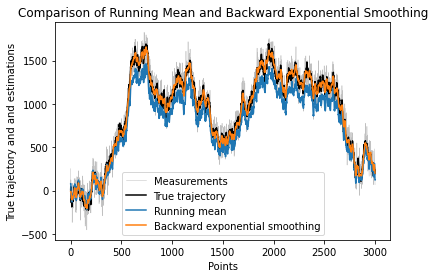

In [45]:
plt.plot(points, Z, linewidth=0.5, color='silver', label='Measurements')
plt.plot(points, X, color='black', label='True trajectory')
plt.plot(points, run_mean, label='Running mean')
plt.plot(points, backwrd_exp_smooth, label='Backward exponential smoothing')
plt.title('Comparison of Running Mean and Backward Exponential Smoothing')
plt.xlabel('Points')
plt.ylabel('True trajectory and and estimations')
plt.legend()
plt.show()

The comparison of methods is based on comparison of deviation variance indicators.

\begin{equation}
    I_d = \sum_{i=1}^N (z_i - X_i)^2
\end{equation}
\begin{equation}
I_v = \sum_{i=1}^{N-2} (X_{i-2} - X_{i-1} + X_i)^2
\end{equation}

In [46]:
# Deviation indicator
deviation_RM = deviation(Z, run_mean) # deviation indicator for running mean estimations
deviation_BS = deviation(Z, backwrd_exp_smooth) # deviation indicator for backward smoothing estimations
print(f'Deviation indicators:  Running mean = {round(deviation_RM)}  |  Backward exponential smoothing = {round(deviation_BS)}')

# Variability indicator
variability_RM = variability(run_mean) # variability indicator for running mean estimations
variability_BS = variability(backwrd_exp_smooth) # variability indicator for backward smoothing estimations
print(f'Variability indicators:  Running mean = {round(variability_RM)}  |  Backward exponential smoothing = {round(variability_BS)}')

Deviation indicators:  Running mean = 88941110  |  Backward exponential smoothing = 25066792
Variability indicators:  Running mean = 2401961  |  Backward exponential smoothing = 125225


Backward smoothing provides better values of deviation indicator and variance indicator.Therefore, backward exponential smoothing method is more accurate. 

## Drawbacks of running mean

Firstly, let's switch to another type of trajectory that describes an object motion disturbed by normally distributed random acceleration with 300 points size of trajectory

\begin{equation}
X_i = X_{i-i} + V_{i-1}T + \frac{a_{i-1}T^2}{2}
\end{equation}
\begin{equation}
V_i=V_{i-1}+a_{i-1}T,
\end{equation}

where $X_i$ are coordinates of the object, $T$ is time that changes with time step 0.1, $V$ is velocity, $a_i$ is normally distributed random acceleration with zero mathematical expectation and variance $\sigma_a^2 = 10$. The initial conditions are following: $X_0 = 5$, $V_0 = 0$.

The measurements are done in the same manner as in previous exercise, but with significantly higher noise $\sigma_\eta^2 = 500$. 

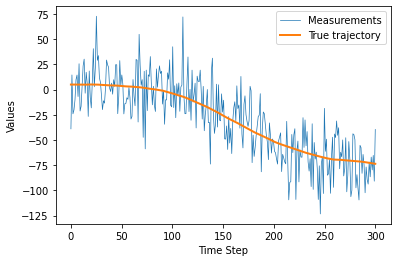

In [47]:
N = 300 # size of trajectory
time_step = 0.1
acc_sigma2 = 10

# Generating the true trajectory X_i
X = get_true_trajectory_with_random_acceleration(init_position=5, init_velocity=0, time_step=time_step,
                                                             points_num=N, acceleration_sigma2=acc_sigma2)

# Generating measurements Z_i
measure_sigma2 = 500
Z, measure_noise = get_measurements(trajectory=X, sigma2=measure_sigma2)

# Plot for trajectory 1 and its measurements
time_axis = np.linspace(time_step, N, N) # for x axis
plt.plot(time_axis, Z, linewidth=0.7, label='Measurements')
plt.plot(time_axis, X, linewidth=2, label='True trajectory')
plt.xlabel('Time Step')
plt.ylabel('Values')
plt.legend()
plt.show()

### Running mean and forward exponential smoothing results

In order to determine the window size $M$ we compare the indicators $I_d$ and $I_v$ for each value of $M$.

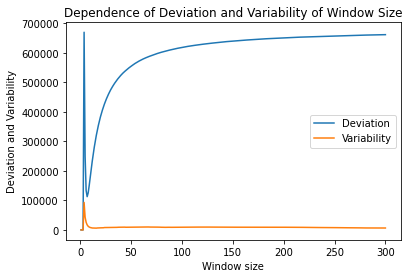

In [48]:
# Determination of the window size M
dev_RM = np.zeros(N)
var_RM = np.zeros(N)

# Iterate through possible window sizes
for M in range(3, N):
    RM = running_mean(Z, M)
    dev_RM[M] = deviation(Z, RM)
    var_RM[M] = variability(RM)

# Plot for Dependence of Deviation and Variability of Window Size
plt.plot(np.linspace(1, N, N), dev_RM, label='Deviation')
plt.plot(np.linspace(1, N, N), var_RM, label='Variability')
plt.title('Dependence of Deviation and Variability of Window Size')
plt.xlabel('Window size')
plt.ylabel('Deviation and Variability')
plt.legend()
plt.show()

The optimal $M$ is about $M=70$.

In [49]:
RM = running_mean(Z, window_size=70)

As for exponential smoothing, we find out the optimal coefficient for exponential smoothing $\alpha \approx 0.1$

In [50]:
# Determination of optimal smoothing coefficient in exponential smoothing
alpha = get_optimal_coefficient(traj_sigma2=acc_sigma2, measure_sigma2=measure_sigma2)
print('Optimal smoothing coefficient is', alpha)

# Exponential smoothing with the determined smoothing coefficient
exp_smooth = exponential_smoothing(initial_state=5,  measurements=Z, smooth_coefficient=alpha)

Optimal smoothing coefficient is 0.13177446878757823


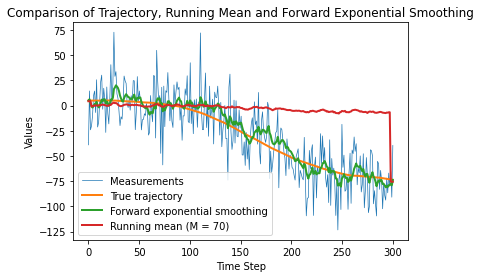

In [51]:
plt.plot(time_axis, Z, linewidth=0.7, label='Measurements')
plt.plot(time_axis, X, linewidth=2, label='True trajectory')
plt.plot(time_axis, exp_smooth, linewidth=2, label='Forward exponential smoothing')
plt.plot(time_axis, RM, linewidth=2, label='Running mean (M = 70)')
plt.title('Comparison of Trajectory, Running Mean and Forward Exponential Smoothing')
plt.xlabel('Time Step')
plt.ylabel('Values')
plt.legend()
plt.show()

Using deviation and variability indicators we can compare these methods. We get greater $I_d$ and $I_v$ for running mean.

In [52]:
# Deviation indicator
deviation_RM = deviation(Z, RM) # deviation indicator for running mean estimations
deviation_ES = deviation(Z, exp_smooth) # deviation indicator for exponential smoothing estimations
print(f'Deviation indicators:  Running mean = {round(deviation_RM)}  |  Backward exponential smoothing = {round(deviation_ES)}')

# Variability indicator
variability_RM = variability(RM) # variability indicator for running mean estimations
variability_ES = variability(exp_smooth) # variability indicator for exponential smoothing estimations
print(f'Variability indicators:  Running mean = {round(variability_RM)}  |  Backward exponential smoothing = {round(variability_ES)}')

Deviation indicators:  Running mean = 591875  |  Backward exponential smoothing = 120096
Variability indicators:  Running mean = 9701  |  Backward exponential smoothing = 5385


## Conclusion

1. The first part shows how significant can be the application of additional performance to smooth data. Due to implementation of backward exponential smoothing the better results were achieved. 

2. In the second part, normally distributed random noise of measurements had a quite large variance what causes scatter results of measurements. To smooth this trajectory of measurements out the bigger value of the window size M of running mean and smaller coefficient $\alpha$ were taken. However, the empirically founded M and following running mean showed results closer to the true trajectory comparing  to forward exponential smoothing. Also, we can see that the deviation indicators for both running mean and forward exponential are almost the same but variability indicators of running mean method less than forward exponential that show us the more index of smoothing.

# **Exercise 3.** 3D surface filtration using forward-backward smoothing

The true surface and its noisy measurements are visualized below.

In [53]:
true_surface = np.loadtxt('true_surface.txt') # true surface to compare the estimation results
measured_surface = np.loadtxt('noisy_surface.txt') # available measurements to work with

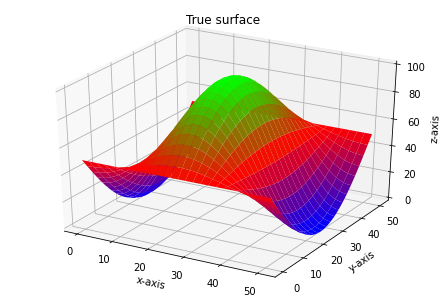

In [54]:
# Plotting the true surface
fig = plt.figure()
fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(0, true_surface.shape[0], true_surface.shape[0])
y = np.linspace(0, true_surface.shape[0], true_surface.shape[0])
X, Y = np.meshgrid(x, y)
Z = true_surface
ax.plot_surface(X, Y, Z, cmap='brg')
plt.title('True surface')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
plt.show()

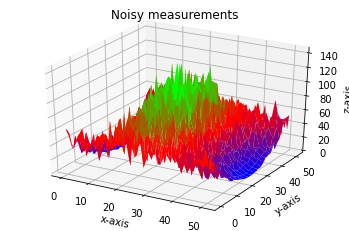

In [55]:
# Plotting the measurements
ax = plt.axes(projection='3d') # coordinate system
x = np.linspace(0, measured_surface.shape[0], measured_surface.shape[0])
y = np.linspace(0, measured_surface.shape[0], measured_surface.shape[0])
X, Y = np.meshgrid(x, y)
Z = measured_surface
ax.plot_surface(X, Y, Z, cmap='brg')
plt.title('Noisy measurements')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
plt.show()

## Variance of deviation of noisy surface from the true one

The variance of deviation is defined with the following equation:

\begin{equation}
    \sigma^2 =\frac{1}{N} \sum_{k=1}^N (X_i - Z_i)^2
\end{equation}

where $X_i$ are true values of surface and $Z_i$ are noisy values of surface.

The variance of deviation of comparing noisy and true surface is 120.63

In [56]:
# Determination of variance of deviation of noisy surface from the true one
measure_sigma2 = np.mean((true_surface - measured_surface)**2)
print(measure_sigma2)

120.63742637237216


## Forward-backward exponential smoothing

In this case, the exponential smoothing is performed in 4 steps

  1. Forward smoothing of rows
  2. Backward smoothing of rows
  3. Forward smoothing of columns
  4. Backward smoothing of columns

The smoothing constant is set to $\alpha = 0.335$. The progress of smoothing is represented in figures below.


In [57]:
Alpha = 0.335

# Step 1: Forward exponential smoothing of rows (from left to right)
forward_rows = exponential_smoothing(initial_state=measured_surface[0], measurements=measured_surface,
                                     smooth_coefficient=Alpha)

# Step 2: Backward exponential smoothing of results obtained at step 1 (from right to left)
backward_rows = backward_exponential_smoothing(forward_exp_smooth=forward_rows, smooth_coefficient=Alpha)

# Step 3: Forward exponential smoothing of results obtained at step 2 along the columns (from bottom to top)
forward_cols = exponential_smoothing(initial_state=backward_rows.T[0], measurements=backward_rows.T,
                                     smooth_coefficient=Alpha)

# Step 4: Backward exponential smoothing of results obtained at step 3 along the columns (from top to bottom)
backward_cols = backward_exponential_smoothing(forward_exp_smooth=forward_cols, smooth_coefficient=Alpha)

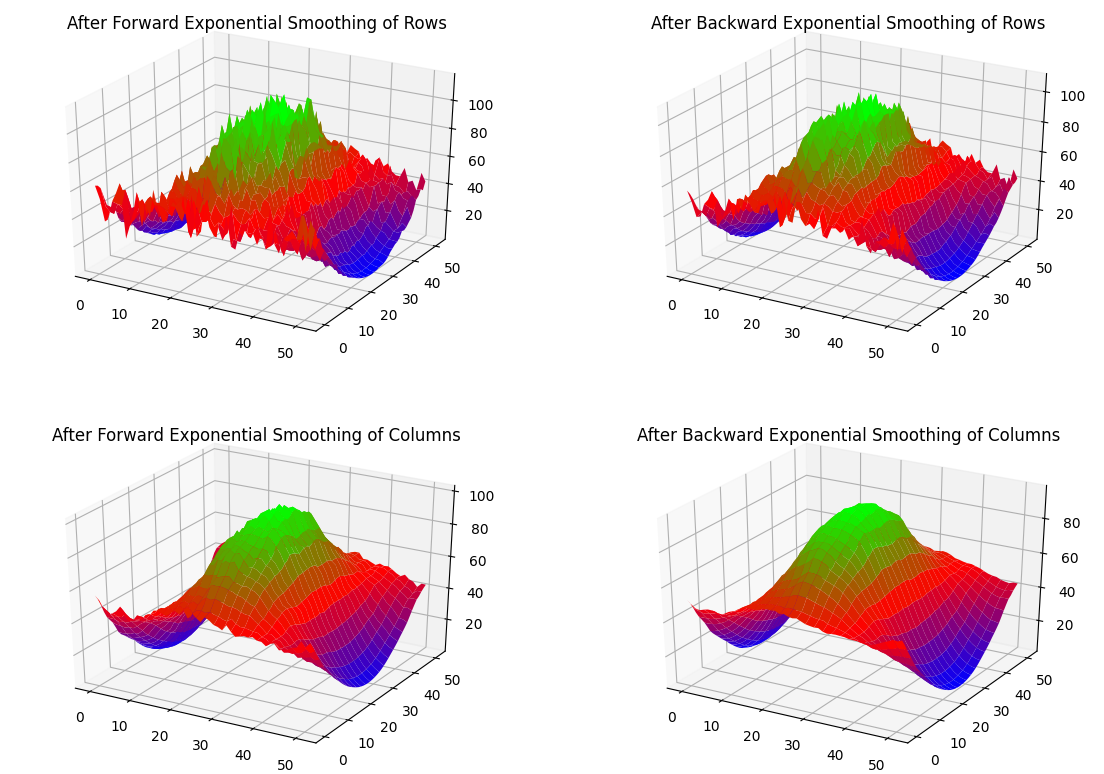

In [58]:
# Plotting the steps

fig = plt.figure(figsize=(14, 10), dpi=100)
x = np.linspace(0, measured_surface.shape[0], measured_surface.shape[0])
y = np.linspace(0, measured_surface.shape[0], measured_surface.shape[0])
X, Y = np.meshgrid(x, y)

ax1 = fig.add_subplot(221, projection='3d')
plt.title('After Forward Exponential Smoothing of Rows')
Z1 = forward_rows
ax1.plot_surface(X, Y, Z1, cmap='brg')

ax2 = fig.add_subplot(222, projection='3d')
plt.title('After Backward Exponential Smoothing of Rows')
Z2 = backward_rows
ax2.plot_surface(X, Y, Z2, cmap='brg')

ax3 = fig.add_subplot(223, projection='3d')
plt.title('After Forward Exponential Smoothing of Columns')
Z3 = forward_cols.T
ax3.plot_surface(X, Y, Z3, cmap='brg')

ax4 = fig.add_subplot(224, projection='3d')
plt.title('After Backward Exponential Smoothing of Columns')
Z4 = backward_cols.T
ax4.plot_surface(X, Y, Z4, cmap='brg')

plt.show()

The final smoothed surface is pretty close to the true one.

In [60]:
# Determination of variance of deviation of noisy surface from the true one
result_sigma2 = np.mean((true_surface - backward_cols.T)**2)
print(result_sigma2)

# Deviation indicator
result_deviation = deviation(true_surface, backward_cols.T)
print(f'Deviation indicator:  {round(result_deviation)}')

7.139263871735309
Deviation indicator:  18569


## Conlusion

By varying the parameter $\alpha$ one can see different degrees of smoothing. Even small adjustments of $\alpha$ leads to changing the surface dramatically. Small values, for instance, $\alpha = 0.05$ make the surface more flat and the true shape of estimation was lost. The increased values of $\alpha$ lead to more fluid and boiling picture.